In [14]:
using DifferentialEquations, Random, LinearAlgebra, MKL, TensorOperations, DelimitedFiles, Plots

In [3]:

@views function doubleExcitation_memoryTuned(du, u, p, t)
    N, G, Ωₗ, Γₗ, Δₗ, dβₖₗ = p
    βₗ = u[1:N]
    βₖₗ = reshape(u[N+1:end], N, N)

    for l = 1:N
        du[l] = (im * Δₗ[l] - Γₗ[l] / 2) * βₗ[l] - 0.5 * im * Ωₗ[l]  # v2
    end
    mul!(du[1:N], -G, βₗ) # du[1:N] .= - G*βₗ


    for k = 1:N
        Ωₖ = Ωₗ[k]
        Gₖ = G[k, :]
        βₖ_linha = βₖₗ[k, :]
        βₖ = βₗ[k]
        for l = 1:N
            dβₖₗ[k, l] =
                (im * (Δₗ[k] + Δₗ[l]) - 0.5 * (Γₗ[k] + Γₗ[l])) * βₖₗ[k, l] -
                0.5im * (Ωₗ[l] * βₖ + Ωₗ[k] * βₗ[l]) - dot(G[l, :], βₖ_linha) -
                dot(Gₖ, βₖₗ[:, l])
        end
    end
    du[N+1:end] .= dβₖₗ[:]

    return nothing
end



function doubleExcitation_speedTuned(du, u, p, t)
    N, G, Ωₗ, Γₗ, Δₗ, rightIndex, _temp = p
    βₗ = u[1:N]
    βₖₗ = reshape(u[N+1:end], N, N)

    for l = 1:N
        du[l] = (im * Δₗ[l] - Γₗ[l] / 2) * βₗ[l] - 0.5 * im * Ωₗ[l]
    end
    mul!(du[1:N], G, βₗ)

    @tensor begin
        _temp[k, l] = G[l, m] * βₖₗ[k, m] + G[k, m] * βₖₗ[m, l]
    end

    for k = 1:N
        for l = 1:N
            du[N+rightIndex[k, l]] =
                (im * (Δₗ[k] + Δₗ[l]) - 0.5 * (Γₗ[k] + Γₗ[l])) * βₖₗ[k, l] -
                0.5im * (Ωₗ[l] * βₗ[k] + Ωₗ[k] * βₗ[l]) + _temp[k, l]
        end
    end

    return nothing
end








doubleExcitation_speedTuned (generic function with 1 method)

In [71]:
function benchmark_test(p)
        N, G, Ωₗ, Γₗ, Δₗ = p
        #G = rand(ComplexF64, N, N);
        G[diagind(G)] .= 0 # avoid the case "m ≠ l"  for dot product
        G .= -G  # avoid an extra operation of negative ("-") inside the TensorOperations

        #Ωₗ = rand(ComplexF64, N)
        #Γₗ = rand(ComplexF64, N)
        #Δₗ = rand(N)
        rightIndex = LinearIndices(G)
        _temp = similar(G)


        p_memory = N, G, Ωₗ, Γₗ, Δₗ, _temp
        p_speed = N, G, Ωₗ, Γₗ, Δₗ, rightIndex, _temp

        u0 = rand(ComplexF64, N + N^2)*0

        prob_memory = ODEProblem(doubleExcitation_memoryTuned, u0, (0.0, 10.0), p_memory)
        prob_speed = ODEProblem(doubleExcitation_speedTuned, u0, (0.0, 10.0), p_speed)

        sol_memory  = solve(prob_memory, saveat=0.05) #
        sol_speed   = solve(prob_speed, saveat=0.05)
        sol = sol_speed

        t  = sol.t
        #print(length(t))

        β_full = sol.u
        
        β_full = reduce(hcat,β_full)
        #print(length(βₗ))
        #βₖₗ = [reshape(sol.u[i][N+1:end], N, N) for i in 1:length(sol.u)]


        #printls(p_memory[:length(p_memory)-1])

        
        #writedlm("../time_test.csv", t, ",")
        #writedlm("../beta_full_test.csv", β_full, ",")
        
        return t, β_full, sol
end


#N = 2
#G = ComplexF64[[0.5 0.5]; [0.5 0.5]]
#Γₗ= ComplexF64[1, 1]
#Ωₗ= Float64[0.1, 0.1 ]
#Δₗ= Float64[20,20 ]
#		
#p = N, G, Ωₗ, Γₗ, Δₗ 
#
#benchmark_test(p)
#


benchmark_test (generic function with 1 method)

In [72]:
G = ComplexF64[[1 -0.06+0.8im]; [-0.06 + 0.8im 0.5]]

2×2 Matrix{ComplexF64}:
   1.0+0.0im  -0.06+0.8im
 -0.06+0.8im    0.5+0.0im

In [73]:
N = 2
G = ComplexF64[[1 -0.006+0.8im]; [-0.006 + 0.8im 1]]
Γₗ= ComplexF64[2, 2]
Ωₗ= Float64[-0.08, 0.03 ]
Δₗ= Float64[20.0,20.0 ]

p = N, G, Ωₗ, Γₗ, Δₗ 

(2, ComplexF64[1.0 + 0.0im -0.006 + 0.8im; -0.006 + 0.8im 1.0 + 0.0im], [-0.08, 0.03], ComplexF64[2.0 + 0.0im, 2.0 + 0.0im], [20.0, 20.0])

In [74]:
t, β, sol =  benchmark_test(p)

([0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45  …  9.55, 9.6, 9.65, 9.7, 9.75, 9.8, 9.85, 9.9, 9.95, 10.0], ComplexF64[0.0 + 0.0im -0.0008898293332511651 + 0.0016453553900826075im … -0.0019950614136181833 + 9.966909985263473e-5im -0.0019949723710093077 + 9.966954720125811e-5im; 0.0 + 0.0im 0.00033368599996918684 - 0.0006170082712809779im … 0.0007481480301068186 - 3.737591244473828e-5im 0.0007481146391284905 - 3.737608020047201e-5im; … ; 0.0 + 0.0im 6.675360369614818e-7 + 1.1140023574736164e-6im … -1.4141627836769362e-6 + 1.6632112888340622e-7im -1.418517529218873e-6 + 1.1383220860901882e-7im; 0.0 + 0.0im -2.3589226869156772e-7 - 4.216498537305787e-7im … 5.157191544029217e-7 - 7.776485601569186e-8im 5.201401689518672e-7 - 2.5272842342094158e-8im], OrdinaryDiffEq.ODECompositeSolution{ComplexF64, 2, Vector{Vector{ComplexF64}}, Nothing, Nothing, Vector{Float64}, Vector{Vector{Vector{ComplexF64}}}, ODEProblem{Vector{ComplexF64}, Tuple{Float64, Float64}, true, Tuple{Int64, Matrix{Co

In [75]:
β[1,:]

201-element Vector{ComplexF64}:
                    0.0 + 0.0im
 -0.0008898293332511651 + 0.0016453553900826075im
  -0.002664153453925579 + 0.0017787403239824247im
 -0.0036828354448165744 + 0.00042706794829818113im
 -0.0031244667604515513 - 0.0010830115798363233im
 -0.0016287765684489144 - 0.001412183023364845im
 -0.0005965851485591197 - 0.0003841629756690804im
 -0.0008889489846644709 + 0.0009703884620787935im
   -0.00212343585643082 + 0.0014325445437208923im
  -0.003127826514649249 + 0.0006819473726394919im
  -0.003043233001775305 - 0.0005077684650925107im
  -0.002047469191222476 - 0.001051513455396077im
 -0.0011004643578226712 - 0.0005339308744586516im
                        ⋮
  -0.001994871612467611 + 9.981950888685562e-5im
 -0.0019949952170100877 + 9.9898771172407e-5im
 -0.0019951221815803677 + 9.984057282195954e-5im
  -0.001995140851725577 + 9.970903357622972e-5im
  -0.001995045161604908 + 9.962648937562077e-5im
  -0.001994929909992367 + 9.966065803145077e-5im
 -0.001994898029534

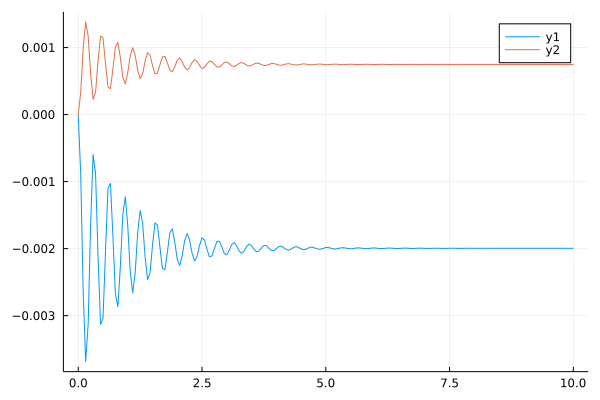

In [76]:
plot(sol.t,  real(β[1,:]))
plot!(sol.t, real(β[2,:]))

In [77]:
Boa tarde Noel! Tudo bem? 


O Romain disse que você é o super expert em Julia. Eu estou tendo uma dúvida e gostaria ver se você consegue me ajudar.

Originalmente, todo meu projeto eu fiz em python, agora, temos interesse em optimizar as simulações e usaremos Julia.
No meu projeto eu já implementei as EDOs de single excitation no python que voce implementou aqui.

Eu gostaria implementar suas EDOs (e novas que a gente tem) em Julia mas rodando um programa python usando pyjulia 
(pois gostaria reaproveitar códigos dos cálculas previos da EDO).

Já consegui rodar seu programa com inputs de python no meu terminal. No entanto, estou tendo um problema: os dois resultado não estão batendo




Assim, eu estou implementando as mesmas equações do single excitation que você ja implementou em Julia





LoadError: syntax: extra token "tarde" after end of expression

In [21]:
real(β_full[1,:])

1-element Vector{Vector{Float64}}:
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

In [18]:
plot(t, real(β_full[1]) )

BoundsError: BoundsError: attempt to access 6-element Vector{Float64} at index [1:201]